In [34]:
from jax.config import config
config.update("jax_enable_x64", True)

import jax.numpy as jnp
from jax import grad, jacobian, jit, vmap, random, nn, tree_multimap

import haiku as hk

import numpy as np

import matplotlib 
%matplotlib inline
import matplotlib.pyplot as plt

import scipy.linalg as sl
import scipy.optimize

In [2]:
# modification of (somewhat erroneous) code i found here:
# https://www.numbercrunch.de/blog/2014/08/calculating-the-hermite-functions/

# i realized later that everything here can be derived from what is found here:
# https://en.wikipedia.org/wiki/Hermite_polynomials#Hermite_functions
# go to the part of the entry that deals with "Hermite functions" and then
# search for "Recursion relation"

# compute only the n-th Hermite function at all values in the vector x
def oneherm(n, x):
    if n==0:
        return np.ones_like(x)*np.pi**(-0.25)*np.exp(-x**2/2)
    if n==1:
        return np.sqrt(2.)*x*np.pi**(-0.25)*np.exp(-x**2/2)
    h_i_2 = np.ones_like(x)*np.pi**(-0.25)
    h_i_1 = np.sqrt(2.)*x*np.pi**(-0.25)
    for i in range(2, n+1):
        h_i = np.sqrt(2./i)*x*h_i_1 - np.sqrt((i-1.)/i)*h_i_2
        h_i_2, h_i_1 = h_i_1, h_i
    return h_i*np.exp(-x**2/2) 

# compute all Hermite functions up to the n-th one at all values in the vector x
def allherm(n, x):
    out = np.zeros((n+1, x.shape[0]))
    h_i_2 = np.ones_like(x)*np.pi**(-0.25)
    out[0,:] = h_i_2*np.exp(-x**2/2)
    if n==0:
        return out
    h_i_1 = np.sqrt(2.)*x*np.pi**(-0.25)
    out[1,:] = h_i_1*np.exp(-x**2/2)
    if n==1:
        return out
    for i in range(2, n+1):
        h_i = np.sqrt(2./i)*x*h_i_1 - np.sqrt((i-1.)/i)*h_i_2
        h_i_2, h_i_1 = h_i_1, h_i
        out[i,:] = h_i*np.exp(-x**2/2)
    return out


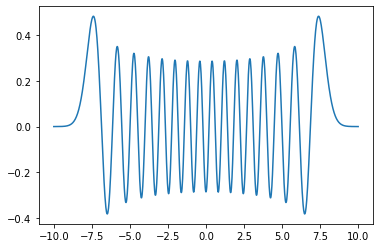

In [51]:
xvec, dx = np.linspace(-10, 10, 1024, retstep=True)
plt.plot(xvec, oneherm(30, xvec))
plt.show()

In [4]:
# check orthonormality
maxdeg = 20
hermmat = allherm(maxdeg, xvec)
print(hermmat.shape)
orthcheck = (hermmat @ hermmat.T) * dx
print(np.linalg.norm(orthcheck - np.eye(maxdeg+1)))

# compute pseudoinverse that can be used to obtain coefficients for a given function
herminv = sl.pinv(hermmat.T) 

(21, 512)
3.4217060819949764e-15


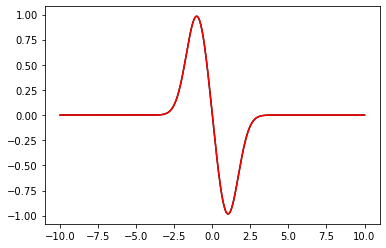

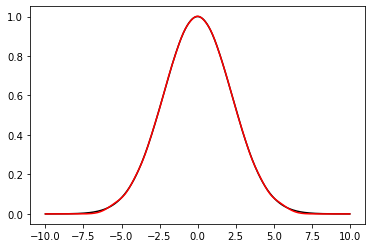

In [5]:
# see if we can find the Hermite function representation of a function in $L^2(\mathbb{R})$
def mypot(x):
    return -np.exp(-(x-1)**2) + np.exp(-(x+1)**2)

hermcoef = herminv @ mypot(xvec)
reconpot = hermcoef @ hermmat

plt.plot(xvec, mypot(xvec), color='black')
plt.plot(xvec, reconpot, color='red')
plt.show()

# try it again for another function in $L^2(\mathbb{R})$
def mypot2(x):
    return np.exp(-0.1*x**2)

hermcoef2 = herminv @ mypot2(xvec)
reconpot2 = hermcoef2 @ hermmat

plt.plot(xvec, mypot2(xvec), color='black')
plt.plot(xvec, reconpot2, color='red')
plt.show()

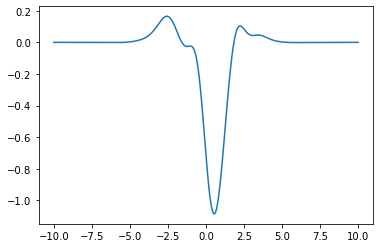

In [6]:
# exponential decay that we apply to a random set of coefficients
decay = np.exp(-0.4*np.arange(maxdeg+1))

# form decaying, random set of coefficients
randcoef = np.random.normal(size=(maxdeg+1))*decay

# evaluate potential for the purposes of plotting
randpot = randcoef @ hermmat
plt.plot(xvec, randpot)
plt.show()

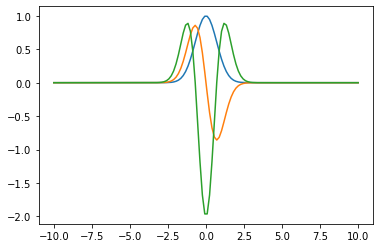

In [55]:
# this is the spatial grid and dx that we'll actually use for learning
num_space_steps = 128
xvec, dx = np.linspace(-10, 10, num_space_steps, retstep=True)
hermmat = allherm(maxdeg, xvec)

space_res = dx
k_res = 1/(num_space_steps * space_res)
k_steps = np.arange(-num_space_steps//2, num_space_steps//2) * k_res
k_terms = np.fft.ifftshift(2 * np.pi * 1j * k_steps)
psi = np.exp(-xvec**2)
psi_hat = np.fft.fft(psi)
psi_hat_prime = k_terms**2 * psi_hat
psi_x = np.fft.ifft(k_terms * psi_hat)
psi_xx = np.fft.ifft(psi_hat_prime)

plt.plot(xvec, psi)
plt.plot(xvec, np.real(psi_x))
plt.plot(xvec, np.real(psi_xx))
plt.show()

4.0472916739422867e-13
2.0437418458800879e-13
2.0437418458800879e-13
3.1913129674956396e-13


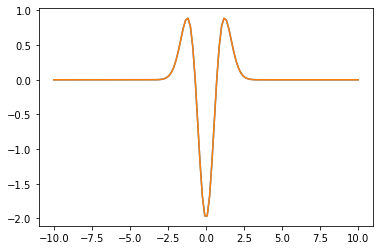

In [56]:
# if you go to this page,
# https://numpy.org/doc/stable/reference/routines.fft.html
# and look up the "implementation details", you'll see an equation where
# 
# A_k = \sum_{m=0}^{n-1} M_{k,m} a_m, 
# 
# with
# 
# M_{k,m} = exp(-2*pi*i*m*k/n)
# 
# here i compute this matrix M in one line and store it in "fftmat"
fftmat = np.exp(-2*np.pi*1j*np.outer(np.arange(num_space_steps), np.arange(num_space_steps))/num_space_steps)

# now i check that multiplying by fftmat is the same as computing the FFT via np.fft.fft
test = fftmat @ psi
print(np.linalg.norm(test - psi_hat))

# we properties of the inverse FFT, we can derive that
ifftmat = (1.0/num_space_steps)*fftmat.conj().T

# let us check that multiplying these gives us the identity matrix
print(np.linalg.norm(fftmat @ ifftmat - np.eye(num_space_steps)))
print(np.linalg.norm(ifftmat @ fftmat - np.eye(num_space_steps)))

# now let us compute the second-derivative matrix
d2mat = ifftmat @ np.diag(k_terms**2) @ fftmat

# let's check if d2mat is Hermitian
print(np.linalg.norm(d2mat - d2mat.conj().T))

# plot second-derivatives computed two different ways
plt.plot(xvec, np.real(psi_xx))
plt.plot(xvec, np.real(d2mat @ psi))
plt.show()

# define the kinetic matrix
kinmat = -0.5*d2mat


In [57]:
# set time step and compute time vector
num_time_steps = 50
dt = 1e-2
tvec = np.arange(num_time_steps)*dt

# form training data
numpots = 10
trainpots = np.zeros((numpots, num_space_steps))
trainwvfns = np.zeros((numpots, num_time_steps, num_space_steps), dtype=np.complex128)

# just to keep things simple, pick the same initial condition for everybody
trainwvfns[:,0,:] = np.exp(-xvec**4)

for i in range(numpots):
    # exponential decay that we apply to a random set of coefficients
    decay = np.exp(-0.4*np.arange(maxdeg+1))

    # form decaying, random set of coefficients
    randcoef = np.random.normal(size=(maxdeg+1))*decay

    # evaluate potential and store
    trainpots[i,:] = randcoef @ hermmat
    
    # form the Hamiltonian
    ham = kinmat + np.diag(trainpots[i,:])
    
    # diagonalize
    hamspec, hamstates = np.linalg.eigh(ham)
    
    # compute unitary propagator
    prop = hamstates @ np.diag(np.exp(-1j*hamspec*dt)) @ hamstates.conj().T
    
    # iterate propagation
    for j in range(num_time_steps-1):
        trainwvfns[i,j+1,:] = prop @ trainwvfns[i,j,:]

trainwvfnsR = np.concatenate([np.real(trainwvfns), np.imag(trainwvfns)], axis=2)
trainwvfnsR = trainwvfnsR.reshape((numpots, -1))

In [58]:
# set up neural network by hand
numlayers = 8
unitsperlayer = 16

def trainpredict(theta):
    # organize theta as follows:
    # weight, bias
    cnt = 0
    for layer in range(numlayers+1):
        if layer==0:
            dim1 = trainwvfnsR.shape[1]
        else:
            dim1 = unitsperlayer
        if layer==numlayers:
            dim2 = num_space_steps
        else:
            dim2 = unitsperlayer
        thisweight = theta[cnt : cnt + (dim1*dim2)].reshape((dim1, dim2))
        

def loss_fn(wvfns, pots):
    mlp = hk.Sequential([
      hk.Linear(64), nn.elu,
      hk.Linear(64), nn.elu,
      hk.Linear(64), nn.elu,
      hk.Linear(64), nn.elu,
      hk.Linear(64), nn.elu,
      hk.Linear(64), nn.elu,
      hk.Linear(64), nn.elu,
      hk.Linear(64), nn.elu,
      hk.Linear(num_space_steps),
    ])
    predpots = mlp(wvfns)
    return jnp.mean(jnp.square(predpots - pots))

loss_fn_t = hk.transform(loss_fn)
loss_fn_t = hk.without_apply_rng(loss_fn_t)
rng = random.PRNGKey(42)
params = loss_fn_t.init(rng, trainwvfnsR, trainpots)

In [59]:
jloss = jit(loss_fn_t.apply)
gradloss = grad(loss_fn_t.apply)
jgradloss = jit(gradloss)

In [60]:
lr = 5e-2
def sgd(param, update):
    return param - lr * update

maxiters = 10000
for i in range(maxiters):
    if i % 100 == 0:
        print(i, jloss(params, trainwvfnsR, trainpots))
    grads = jgradloss(params, trainwvfnsR, trainpots)
    params = tree_multimap(sgd, params, grads)

0 0.08995216015568133
100 0.07618006222913885
200 0.06616803972131477
300 0.0570208615786214
400 0.049249004976447575
500 0.04268611384203872
600 0.037233212413287406
700 0.03409697285792103
800 0.03052719696021431
900 0.027733599137382298
1000 0.02527784403337401
1100 0.02317157080384341
1200 0.02138183361477526
1300 0.019854172888834905
1400 0.01858188505219607
1500 0.01750444072751837
1600 0.016622097853115244
1700 0.015873561412602766
1800 0.015241650298972637
1900 0.01470205086437839
2000 0.01423209367492824
2100 0.01381786179269657
2200 0.013453693958765757
2300 0.013137292636240675
2400 0.012852901531995926
2500 0.012601255164586234
2600 0.012373493482347247
2700 0.012165922465285452
2800 0.011978431112997137
2900 0.011803483559000759
3000 0.011644796511652032
3100 0.011494859537983453
3200 0.011352664590876783
3300 0.011216191137986444
3400 0.01108913253156406
3500 0.010961862094897315
3600 0.010842532179390026
3700 0.010724789516406043
3800 0.01060712641669229
3900 0.010491977

In [63]:
lr = 1e-2
def sgd(param, update):
    return param - lr * update

maxiters = 10000
for i in range(maxiters):
    if i % 100 == 0:
        print(i, jloss(params, trainwvfnsR, trainpots))
    grads = jgradloss(params, trainwvfnsR, trainpots)
    params = tree_multimap(sgd, params, grads)

0 0.004639304983004272
100 0.0044486184496039345
200 0.004440410356097966
300 0.004432398141535297
400 0.004424529109769469
500 0.0044167738114051286
600 0.004409113132635739
700 0.004401533909692917
800 0.0043940267777332785
900 0.00438658490183164
1000 0.004379203018571648
1100 0.004371876944895875
1200 0.004364603341850061
1300 0.004357379354525367
1400 0.004350202735988742
1500 0.0043430714510446135
1600 0.004335983839034406
1700 0.004328938411774671
1800 0.004321933700882476
1900 0.004314968498602321
2000 0.004308041585426081
2100 0.004301151883029921
2200 0.004294298301079704
2300 0.004287479887587096
2400 0.004280695755378035
2500 0.004273945012837976
2600 0.004267226824538415
2700 0.004260540414724407
2800 0.004253884999805226
2900 0.004247259833091059
3000 0.004240664202089516
3100 0.004234097425379395
3200 0.0042275588292454555
3300 0.004221047774527471
3400 0.0042145637092074455
3500 0.00420810605775564
3600 0.004201674323201481
3700 0.004195267928155041
3800 0.0041888863317

In [64]:
lr = 1e-2
def sgd(param, update):
    return param - lr * update

maxiters = 100000
for i in range(maxiters):
    if i % 100 == 0:
        print(i, jloss(params, trainwvfnsR, trainpots))
    grads = jgradloss(params, trainwvfnsR, trainpots)
    params = tree_multimap(sgd, params, grads)

0 0.003824510531873734
100 0.0038189312831505176
200 0.00381335689404599
300 0.00380778719503627
400 0.003802222044755386
500 0.00379666126238974
600 0.0037911047128388166
700 0.003785552214516367
800 0.003780003592096421
900 0.0037744586586222154
1000 0.0037689172336783285
1100 0.0037633791672184377
1200 0.003757844746945155
1300 0.003752314185061433
1400 0.003746787313794332
1500 0.0037412639451531674
1600 0.003735743971148182
1700 0.003730227246731048
1800 0.0037247135313560886
1900 0.0037192026654045275
2000 0.0037136944969339003
2100 0.0037081888838863156
2200 0.003702685718347849
2300 0.003697184855859875
2400 0.0036916861611737783
2500 0.0036861895277554
2600 0.003680694839035203
2700 0.0036752019275568997
2800 0.003669710904141083
2900 0.0036642226918077205
3000 0.003658737272846109
3100 0.003653254563989957
3200 0.0036477748580225674
3300 0.003642297885070046
3400 0.003636823365147845
3500 0.0036313513627182488
3600 0.00362588181668491
3700 0.003620414472422428
3800 0.00361494

30200 0.002247621135494562
30300 0.002243120118627848
30400 0.002238626548977396
30500 0.002234140406967315
30600 0.002229661692342687
30700 0.002225190400732586
30800 0.0022207265261431903
30900 0.002216270049819253
31000 0.0022118209677279813
31100 0.002207379278284157
31200 0.0022029449729581148
31300 0.002198518068885798
31400 0.0021940985719484628
31500 0.0021896864887896387
31600 0.0021852818274684153
31700 0.002180884577344433
31800 0.0021764947345642334
31900 0.00217211233484163
32000 0.0021677373548864946
32100 0.0021633697823983454
32200 0.002159009602784956
32300 0.00215465684105719
32400 0.002150311498792253
32500 0.0021459735938940045
32600 0.0021416430781947514
32700 0.0021373200086067454
32800 0.0021330043668047354
32900 0.0021286961554417604
33000 0.002124395375844255
33100 0.0021201020339241886
33200 0.0021158161308705513
33300 0.0021115376708641382
33400 0.002107266649833982
33500 0.002103003101788184
33600 0.0020987469735252616
33700 0.0020944983026591857
33800 0.002

59800 0.0012398130603228593
59900 0.0012373777239513917
60000 0.0012349462004635158
60100 0.0012325184214921623
60200 0.00123009434987528
60300 0.001227673840417518
60400 0.0012252568346024651
60500 0.0012228442678947251
60600 0.001220438781527847
60700 0.0012180404051520962
60800 0.0012156490405637365
60900 0.0012132646046594871
61000 0.0012108870135137723
61100 0.0012085161974395972
61200 0.0012061520885552522
61300 0.0012037946229782395
61400 0.001201443740297804
61500 0.0011990993864789447
61600 0.001196761504073784
61700 0.001194430034706273
61800 0.0011921049262660223
61900 0.0011897861450358882
62000 0.0011874736334683287
62100 0.0011851673416200326
62200 0.00118286724519505
62300 0.001180573304610212
62400 0.0011782855120916044
62500 0.0011760038236942462
62600 0.001173728229523498
62700 0.0011714586837179174
62800 0.0011691951535199314
62900 0.0011669376019470712
63000 0.001164685993062635
63100 0.0011624402915154431
63200 0.0011602004627012952
63300 0.0011579664725451869
6340

89300 0.0007193647738569772
89400 0.0007181024142292093
89500 0.0007168421567498271
89600 0.0007155838930194886
89700 0.0007143275794838131
89800 0.0007130731991325404
89900 0.0007118206922898745
90000 0.0007105700434364339
90100 0.000709321991138382
90200 0.0007080773646130259
90300 0.0007068360649781732
90400 0.0007055980179477996
90500 0.0007043631474529103
90600 0.00070313138986813
90700 0.0007019026841569096
90800 0.0007006769766321581
90900 0.0006994542174198273
91000 0.0006982343714354491
91100 0.0006970173903473542
91200 0.0006958032355961293
91300 0.0006945918708796784
91400 0.0006933832578966594
91500 0.0006921773735729253
91600 0.0006909741815589261
91700 0.0006897736523814574
91800 0.0006885757702870536
91900 0.0006873804880942339
92000 0.00068618777374196
92100 0.0006849976318276534
92200 0.000683810025041171
92300 0.0006826249279254408
92400 0.0006814423181372493
92500 0.0006802621830842317
92600 0.0006790844854494831
92700 0.0006779091840013889
92800 0.000676736322518127